# Rainbow on Mario

In [1]:
# Windows: first, install Visual Studio build tools
# pip install nes-py
# pip install gym-super-mario-bros

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

In [2]:
# Loading LegoRL library
import sys
sys.path.append('.\\src')  # path to folder with library
from LegoRL import *

Gameboy has 12 buttons, each can be either on or off at each moment of time (sounds familiar...). It is not a good idea to have 2^12 actions in action space, so there are some sets of buttons combinations. COMPLEX_MOVEMENT is considered as the hardest one although it has only 12 combinations.

So, the cardinality of our action space will be 12.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import gym

# Magic "Custom Reward"

In [4]:
# SOURCE: https://github.com/uvipen/Super-mario-bros-A3C-pytorch/blob/master/src/env.py
from gym.spaces import Box
from gym import Wrapper
import cv2
import numpy as np

class CustomReward(Wrapper):
    def __init__(self, env):
        super(CustomReward, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
        self.curr_score = 0
    
    def process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84))[None, :, :] / 255.
        return frame
    
    def step(self, action):
        state, reward, done, info = self.env.step(action)
        
        state = self.process_frame(state)
        
        reward += (info["score"] - self.curr_score) / 40.
        self.curr_score = info["score"]
        if done:
            if info["flag_get"]:
                reward += 50
            else:
                reward -= 50
        return state, reward / 10., done, info

    def reset(self):
        self.curr_score = 0
        return self.process_frame(self.env.reset())


class CustomSkipFrame(Wrapper):
    def __init__(self, env, skip=4):
        super(CustomSkipFrame, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(4, 84, 84))
        self.skip = skip

    def step(self, action):
        total_reward = 0
        states = []
        state, reward, done, info = self.env.step(action)
        for i in range(self.skip):
            if not done:
                state, reward, done, info = self.env.step(action)
                total_reward += reward
                states.append(state)
            else:
                states.append(state)
        states = np.concatenate(states, 0)[:, :, :]
        return states.astype(np.float32), reward, done, info

    def reset(self):
        state = self.env.reset()
        states = np.concatenate([state for _ in range(self.skip)], 0)[:, :, :]
        return states.astype(np.float32)

# Environment

In [5]:
def create_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v0')
        env = JoypadSpace(env, COMPLEX_MOVEMENT)             # we want 12 actions instead of 2^12
        env = CustomReward(env)
        env = CustomSkipFrame(env)
        #env = atari_wrappers.ImageToPyTorch(env)             # pytorch wants channels x W x H
        return env
    return _thunk

In [6]:
env = create_env()()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4, 84, 84)
Action space: Discrete(12)


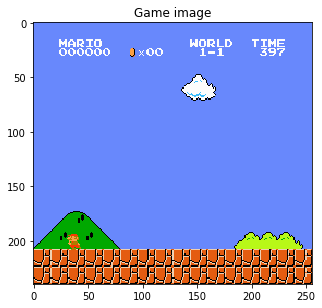

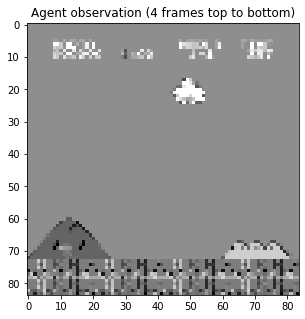

In [7]:
env.reset()
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[5,5])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[5,5])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs[-1], cmap='gray')
plt.show()

## NoisyLinear with parallel envs issue

In [8]:
import math

def HonestNoisyLinear(std_init=0.4):
    class HonestNoisyLinear(nn.Linear):
        """NoisyLinear module for Noisy Net exploration technique"""
        
        def __init__(self, in_features, out_features):
            super(HonestNoisyLinear, self).__init__(in_features, out_features)
            
            self.n = in_features
            self.m = out_features

            sigma_init = std_init / math.sqrt(in_features)
            self.n_params = in_features*out_features + out_features
            
            self.sigma_weight = nn.Parameter(torch.FloatTensor(out_features, in_features).fill_(sigma_init))
            self.sigma_bias = nn.Parameter(torch.FloatTensor(out_features).fill_(sigma_init))
        
        def forward(self, x):
            if self.training:
                # hack: we need to generate matrix in x out, but that's too many samples
                # instead we generate in + out noises and multiply them pairwise
                names = x.names
                x = x.rename(None)

                epsilon_input = torch.randn(*x.shape[:-1], self.n).cuda()
                epsilon_output = torch.randn(*x.shape[:-1], self.m).cuda()

                scale = lambda e: torch.sign(e) * torch.sqrt(torch.abs(e))
                eps_in = scale(epsilon_input)
                eps_out = scale(epsilon_output)
                
                output = (self.weight * x.unsqueeze(-2)).sum(-1) + self.bias
                e = self.sigma_weight * torch.bmm(eps_out.unsqueeze(-1), eps_in.unsqueeze(-2))
                output = output + torch.bmm(e, x.unsqueeze(-1)).squeeze(-1) + self.sigma_bias * eps_out
                return output.rename(*names)
            else:        
                return F.linear(x, self.weight, self.bias)
        
        def magnitude(self):
            # returns summed magnitudes of noise and number of noisy parameters
            return (self.sigma_weight.abs().sum() + self.sigma_bias.abs().sum()).detach().cpu().numpy(), self.n_params
    return HonestNoisyLinear

# Network

Network architecture is taken from curiosity article (nothing fancy).

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(*x.shape[:-3], -1)

class NoisyMarioNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),           
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            HonestNoisyLinear(std_init=0.4)(1152, 256),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        names = x.names
        x = x.rename(None)
        return self.layers(x).refine_names(*names[:-3], "features")

# Model

Rainbow; everything as in the article except bias correction in prioritized replay is turned off.

In [10]:
agent = Composed(
    visualizer      = Visualizer(timer=50),
    player          = Player(policy="q_head", timer=3000, records_file_name="videos/rainbow", record_timer=3000),
    runner          = Runner(policy="q_head", threads=8),
    latency         = NstepLatency(runner="runner", n_steps=3),
    replay          = ReplayBuffer(runner="latency", capacity=100000),
    sampler         = PrioritizedSampler(replay="replay", clip_priorities=10, batch_size=128, cold_start=1000),
    #corrected       = SamplerBiasCorrection(sampler="sampler"),
    updater         = PrioritiesUpdater(sampler="sampler", priority_provider="loss"),
    backbone        = Backbone(NoisyMarioNN()),
    v_head          = ValueHead(backbone="backbone", network=HonestNoisyLinear(), representation=Categorical(-10, 10, 51)(V)),
    q_head          = Dueling(backbone="backbone", network=HonestNoisyLinear(), value_head="v_head", representation=Categorical(-10, 10, 51)(Q)),
    double          = Double(selector="q_head", evaluator="frozen_q_head"),
    target          = Target(evaluator="double"),
    loss            = CriticLoss(sampler="sampler", critic="q_head", target="target"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_v_head   = Frozen(ValueHead)(backbone="frozen_backbone", source="v_head"),
    frozen_q_head   = Frozen(Dueling)(backbone="frozen_backbone", value_head="frozen_v_head", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"], optimizer_args={"lr": 0.0001}, clip_gradients=1),
)

..\c10/core/TensorImpl.h:864: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.


# RUN

In [11]:
system = System(agent, gamma=0.9, file_name="models/legorl_rainbow", save_timer=1000, make_env=create_env)

runner: environment initialization... Finished.
Adding new head <v_head> to <backbone>:
  Input shape is (4, 84, 84)
  Backbone feature size is 256
  Desired output is torch.Size([51])
Adding new head <q_head> to <backbone>:
  Input shape is (4, 84, 84)
  Backbone feature size is 256
  Desired output is torch.Size([51, 12])


In [12]:
# loading model from backup
system.load()

In [13]:
# some issues during training, had to reload :(
system.reload_messages

['iteration 211000: reloaded (replay buffers are lost)',
 'iteration 214000: reloaded (replay buffers are lost)',
 'iteration 216000: reloaded (replay buffers are lost)']

In [ ]:
system.run(1000000)

In [16]:
system.save()

In [ ]:
rollout = agent.player.play(render=True)

# Training statistics

In [17]:
print("Learning time in hours: ", sum(system.logger['time']) / 60 / 60)
print("Frames done: ", agent.runner.frames_done)
print("Fps: ", agent.runner.frames_done / sum(system.logger['time']))
print("Episodes played: ", agent.runner.episodes_done)

Learning time in hours:  84.49090910732747
Frames done:  2359600
Fps:  7.757573582405697
Episodes played:  2696


Text(0.5, 0, 'episode')

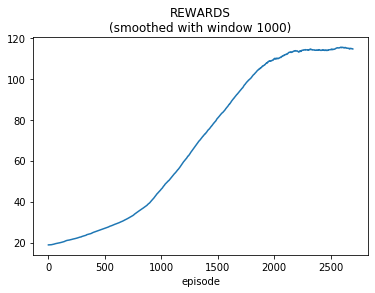

In [25]:
from LegoRL.utils.visualizer import sliding_average
plt.plot(sliding_average(system.logger['rewards'], 1000))
plt.title("REWARDS\n(smoothed with window 1000)")
plt.xlabel("episode")

## Animation experiments

In [21]:
def show_animation(rollout):
    """
    generates animation inline notebook:
    input: rollout - Rollout
    """
    from matplotlib import pyplot as plt
    from matplotlib import animation, rc
    from IPython.display import HTML
    
    frames = rollout["frames"]
    rewards = [0] + [rollout["rewards"][t][0] for t in range(len(rollout["rewards"]))]
    actions = [""] + [rollout["actions"][t][0] for t in range(len(rollout["actions"]))]
    cumrewards = [0] + list(np.cumsum(rewards))
    
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    rewards_patch = plt.text(0, 0, "Reward: " + ("%0.2f" % (cumrewards[0])) + " (" + ("%0.2f" % (rewards[0])) + ")", size=15,
                                 ha="left", va="top",
                                 bbox=dict(boxstyle="round",
                                           ec=(0.5, 1., 0.5),
                                           fc=(0.8, 1., 0.8),
                                           )
             )
    actions_patch = plt.text(0, 40, "Action: " + str(actions[0]), size=15,
             ha="left", va="top",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    def animate(i):
        patch.set_data(frames[i])
        rewards_patch.set_text("Reward: " + ("%0.2f" % (cumrewards[i])) + " (" + ("%0.2f" % (rewards[i])) + ")")
        actions_patch.set_text("Action: " + str(actions[i]))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    return HTML(anim.to_jshtml())

In [ ]:
show_animation(rollout)